In [1]:
import os 

testset = os.path.join(os.getcwd(), 'dataset', 'testset')
trainingset = os.path.join(os.getcwd(), 'dataset', 'pexels')
#trainingset = os.path.join(os.getcwd(), 'dataset', 'trainingset')
print(testset, trainingset)

/host/SceneClassification/dataset/testset /host/SceneClassification/dataset/pexels


In [2]:
os.listdir(testset)

['snow', 'grass', 'sand', 'ground']

In [3]:
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import torch
import torchvision.models as pretrained_models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
std_image_size = 224
std_scale = 256

def get_trainings_transformations():
    return transforms.Compose([
            #transforms.Resize(self.std_scale),
            #transforms.Lambda(lambda x: x.convert('L')),
            transforms.RandomResizedCrop(std_image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def get_test_transformations():
    return transforms.Compose([
            #transforms.Lambda(lambda x: x.convert('L')),
            transforms.Resize(std_scale),
            transforms.CenterCrop(std_image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def load_dataset(data_path, transformations, batch_size = 64):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformations
    )

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader, dataset.classes


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, dset_classes = load_dataset(trainingset, get_trainings_transformations())
net = pretrained_models.resnet50(pretrained=True)
print(dset_classes)
net.fc = torch.nn.Linear(2048, len(dset_classes))
net = net.to(device) 
#net.load_state_dict(torch.load(os.getcwd() + '/serialized_nets/terrain_v100'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # move them to gpu if accessible
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    if epoch % 10 == 9:
        torch.save(net.state_dict(), os.getcwd() + f'/serialized_nets/terrain_v' + str(epoch+1))

print('Finished Training')

['grass', 'ground', 'sand', 'snow']
[1,   100] loss: 1.129
[1,   200] loss: 0.990
[2,   100] loss: 0.911
[2,   200] loss: 0.924
[3,   100] loss: 0.885
[3,   200] loss: 0.872
[4,   100] loss: 0.833
[4,   200] loss: 0.830
[5,   100] loss: 0.823
[5,   200] loss: 0.821
[6,   100] loss: 0.805
[6,   200] loss: 0.810
[7,   100] loss: 0.776
[7,   200] loss: 0.813
[8,   100] loss: 0.782
[8,   200] loss: 0.804
[9,   100] loss: 0.785
[9,   200] loss: 0.803
[10,   100] loss: 0.762
[10,   200] loss: 0.762
[11,   100] loss: 0.749
[11,   200] loss: 0.770
[12,   100] loss: 0.746
[12,   200] loss: 0.742
[13,   100] loss: 0.738
[13,   200] loss: 0.729
[14,   100] loss: 0.730
[14,   200] loss: 0.737
[15,   100] loss: 0.719
[15,   200] loss: 0.749
[16,   100] loss: 0.733
[16,   200] loss: 0.717
[17,   100] loss: 0.718
[17,   200] loss: 0.709
[18,   100] loss: 0.686
[18,   200] loss: 0.735
[19,   100] loss: 0.714
[19,   200] loss: 0.702
[20,   100] loss: 0.710
[20,   200] loss: 0.698
[21,   100] loss: 0.69

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

grass ground  sand  sand


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


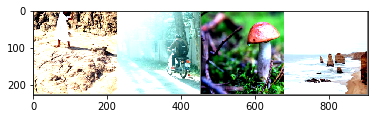

GroundTruth:  ground ground ground  sand


In [15]:
testloader, classes = load_dataset(testset, get_test_transformations(), batch_size=4)
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = net.to('cpu')
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  ground grass grass  sand


In [17]:
correct = 0
total = 0
net.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of grass : 74 %
Accuracy of ground : 46 %
Accuracy of  sand : 64 %
Accuracy of  snow : 74 %


In [ ]:
torch.save(net.state_dict(), os.getcwd() + f'/serialized_nets/terrain_v' + str(epoch+1))